# LSMLSDA Programming Exercise Week 1
## Modelling decision making with a drift-diffusion model

This exercise was kindly provided by Prof. Sprekeler, Modelling of Cognitive Processes Group, BCCN Berlin. 


We will explore the reaction time distribution of the drift diffusion model
for perceptual decision making. 

Important paper: https://www.ncbi.nlm.nih.gov/pubmed/17600525

General information: https://en.wikipedia.org/wiki/Two-alternative_forced_choice

In [1]:
# imports 
import numpy as np
import scipy
import pandas
import matplotlib.pyplot as plt


### Part 1
Our goal is to simulate a decision making process. A very much simplified approach to that is to simulate a biased random walk: We simulate an internal decision variable, e.g., some neural activity, using a single scalar variable. At every time step, the variable evolves in a certain direction due to sensory evidence for a decision in that direction (drift, $\mu$), plus noise (diffusion, $\sigma$). Such a model is often called a drift-diffusion model. A simple form of the drift diffusion model is given by

$$
dX = \mu \mathrm{dt} + \sigma \mathrm{dW} ,
$$

To simulate the decision making process as a drift-diffusion process we have to integrate this equation. Because it is a stochastic differential equation (sde) we cant use standard implementation like scipy odeint for integration. Therefore, your first task is to implement your own Euler-Marayuma sde solver.

Euler-Maruyama is an extension of the simple Euler method to stochastic differential equations where we here only consider Gaussian noise processes. Euler-Maruyama
integrates differential equations of the form

\begin{align}
dX(t) &= f(X(t))\mathrm{dt} + g(X(t))\mathrm{dW}(t)
\end{align}

here f (X(t)) is the deterministic part of the differential equation and g(X(t))dW (t) is
the stochastic part where dW (t) is a random variable. Euler-Maruyama consists of the
following update which your function has to implement:

\begin{align}
X_t = X_{t-1} + f(X_{t-1}) \Delta t + g(X_{t-1}) \sqrt{\Delta t} W_t
\end{align}

Each $W_t$ is a sample from a standard normal distribution. For more information about
Euler-Maruyama see Higham (2001), or Wikipedia.
Write a function euler_maruyama(ffun, gfun, x0, t, \**args) which implements this equation
and which behaves like scipy odeint. Note that we have defined args as a dictionary which differs
from scipy odeint where args is a tuple. This makes it easier to change individual parameters of
the model functions later.

Start with $X = 0$. Choose
$\sigma = 0.5, \mu = 0.2$. Run 5 simulations of 10 seconds length with $dt = 0.01s$ and
plot the results.

**Hint**: A single simulation is a trace of values starting at X=0 and evolving as a random walk with a drift towards more positive (or negative) values. Plot all 5 traces in a single plot with different colors. 

In [2]:
# your code 
def ffun(x, mu):
    return mu;

def gfun(x, sigma):
    return sigma;

def euler_maruyama(ffun, gfun, x0, t, **kwargs):
    mu = kwargs.get('mu')
    sigma = kwargs.get('sigma')
    
    x = np.zeros(len(t))
    dt = t[1]-t[0]
    x[0] = x0
    for i in range(1,t.size):
        Wt = np.random.normal(loc = 0.0, scale = np.sqrt(dt))
        x[i] = x[i-1]+ffun(x[i-1], mu)*dt+gfun(x[i-1], sigma)*Wt
                              
    return x

Text(0.5, 1.0, 'Drift-Difussion Model')

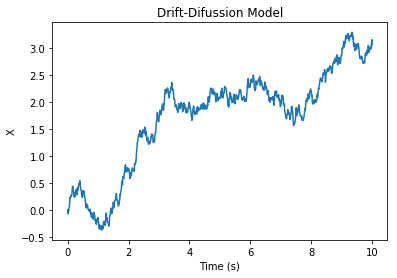

In [3]:
# Test Drift-difusion model
mu = 0.2
sigma = 0.5
# Initial condition    
x0 = 0 
# Time
t = np.linspace(0, 10, 1001)

sol = euler_maruyama(ffun, gfun, x0, t, mu = mu , sigma = sigma )

plt.plot(t,sol)
plt.xlabel('Time (s)')
plt.ylabel('Decision variable X')
plt.title('Drift-Difussion Model')

_Coment: The DDM assumes that in a 2AFC task, the subject is accumulating evidence for one or other of the alternatives at each time step, and integrating that evidence until a decision threshold is reached. As the sensory input which constitutes the evidence is noisy, the accumulation to the threshold is stochastic rather than deterministic – this gives rise to the directed random walk-like behavior. (Source: Wikipedia)_

### Part 2

Plot the percentage of ”up” (X=+a) responses as a function of the drift μ by
simulating 200 trials for a = 1 and the following $\mu$ values: −0.1, 0, 0.1, 0.2, 0.5.

Resimulate trials in which no decision boundary is reached during the simulation.

Plot the results. What happens to this curve if you double, what if you halve the
value of a?


_Response:_
When the decision variable reaches the decision boundary 'a' a decision is made. Increasing the decision boundary would result in a increase of the reaction time (it takes longer to accumulate evidence) and in a reduction of the percentage of correct responses.

Increasing the decison boundary would be the equivalent of taking an important decision that you must take much time to meditate. On the contrary, decreasing the threshold 'a' would be the equivalent of taking a banal decision, you don't need much evidence to decide yourself.

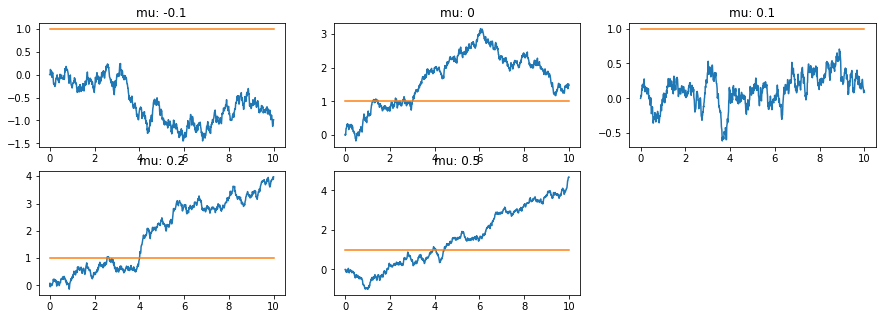

<function matplotlib.pyplot.show(*args, **kw)>

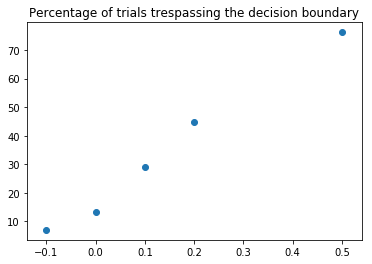

In [5]:
a=1 # Decision threshold
n_trials = 200

# Parameters of the model
sigma = 0.5
mus = [-0.1, 0, 0.1, 0.2, 0.5]
x0 = 0 
t = np.linspace(0, 10, 1001)

results = []

fig, axes = plt.subplots(figsize=(15,5))
# Calculate the percentage of correct responses for each trial
for idx, mu in enumerate(mus):
    ups = np.zeros(n_trials)
    for i in range(n_trials):
        sol = euler_maruyama(ffun, gfun, x0, t, mu = mu , sigma = sigma)
        up = np.sum(sol>=a)
        ups[i] = (up/len(sol))*100 # Percentage
    res = np.average(ups)    
    results.append(res)
    
    # Plot an example of threshold and evidence for each value of mu
    plt.subplot(2,3,idx+1)
    plt.plot(t,sol)
    plt.plot(t,a*np.ones(len(t)))
    plt.title('mu: '+ str(mu))

plt.show()

# Plot the percentage of correct responses as a function of mu
plt.scatter(mus,results)
ax.set_xlabel('mu')
ax.set_ylabel('% of trials')
plt.title('Percentage of trials trespassing the decision boundary')
plt.show

### Part 3

Use the results from the last exercise to pick a value of $\mu$ (with $\sigma = 0.5$) for which
about $70\%$ of the trials result in an ”up” response. Run 2000 trials and record the
reaction times, i.e. the moment when the decision variable X crosses one of the
two decision thresholds at X = ±a (for a = 1), as well as the choice, i.e. which of
the boundaries was hit.

In [6]:
def calculate_reaction_time(sol, threshold):
    '''Function that returns the reaction time and the boundary'''
    # Find the index when the X croses the boundary a
    reaction_time_pos = np.argmax(sol>=a)
    reaction_time_neg = np.argmax(sol<=a)
    if(reaction_time_pos > reaction_time_neg):
        reaction_time = reaction_time_pos
        boundary = a
    else:
        reaction_time = reaction_time_neg
        boundary = -a
        
    return reaction_time, boundary;

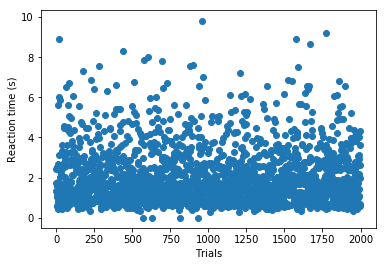

In [7]:
# your code
a=1
n_trials = 2000

# Parameters of the model
mu = 0.5
sigma = 0.5
x0 = 0 
n_seconds = 10
n_samples = 1001
t = np.linspace(0, n_seconds, n_samples)
dt = (n_seconds - 0)/n_samples


# Calculate the reaction times for all trials
reaction_times = np.zeros(n_trials)
boundaries = np.zeros(n_trials)
for i in range(n_trials):
    sol = euler_maruyama(ffun, gfun, x0, t, mu = mu , sigma = sigma)
    reaction_times[i], boundaries[i] = calculate_reaction_time(sol,a)

reaction_times = reaction_times*dt # In seconds

plt.scatter(np.arange(n_trials),reaction_times)        
plt.xlabel('Trials')
plt.ylabel('Reaction time (s)')

plt.show()

### Part 4

Plot a histogram of the reaction times for each of the choices separately, and
compare the distributions. Calculate their individual mean reaction times and
discuss whether (and why) this is what you would have expected.

Can you reproduce qualitatively figure 5b of Gold and Shadlen (2007): increase motion strength (loosely speaking increased drift $\mu$) results in higher percentage correct and reduced mean reaction times?  

_Response_:
In this case the precentage of correct responses increases as the drift increases but the reduced mean reactions time also increase.

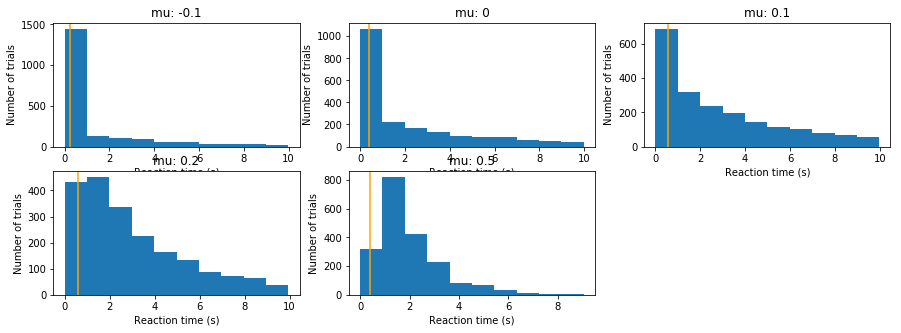

In [20]:
a=1
n_trials = 2000

# Parameters of the model
mus = [-0.1, 0, 0.1, 0.2, 0.5]
sigma = 0.5
x0 = 0 
n_seconds = 10
n_samples = 1001
t = np.linspace(0, n_seconds, n_samples)
dt = (n_seconds - 0)/n_samples

reaction_times = np.zeros((len(mus),n_trials))
boundaries = np.zeros((len(mus),n_trials))
ups = np.zeros((len(mus),n_trials))

fig, axes = plt.subplots(figsize=(15,5))
# For every different mu calculate the reaction times
for id_mu, mu in enumerate(mus):
    for i in range(n_trials):
        sol = euler_maruyama(ffun, gfun, x0, t, mu = mu , sigma = sigma)
        # Calculate the reaction times
        reaction_times[id_mu,i], boundaries[id_mu, i] = calculate_reaction_time(sol,a)
        # Calculate the percentage of correct responses
        up = np.sum(sol>=a)
        ups[id_mu,i] = (up/len(sol))*100
        
    reaction_times = reaction_times*dt # In seconds
    plt.subplot(2,3,id_mu+1)
    plt.hist(reaction_times[id_mu,:])
    plt.axvline(x=np.average(reaction_times),color='orange')
    plt.xlabel('Reaction time (s)')
    plt.ylabel('Number of trials')
    plt.title('mu: '+ str(mu))
plt.show()


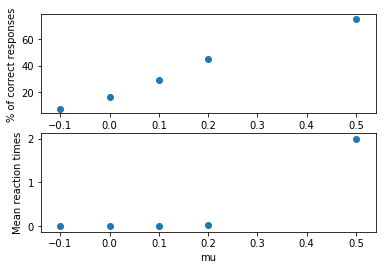

In [21]:
# Mean Response times
meanRT = np.average(reaction_times,1)
# Percentage correct
correct = np.average(ups,1)

# Plot the results

plt.subplot(2,1,1)
plt.scatter(mus,correct)
plt.ylabel('% of correct responses')

plt.subplot(2,1,2)
plt.scatter(mus,meanRT)
plt.ylabel('Mean reaction times')
plt.xlabel('mu')

plt.show()

### Part 5

Implement an extended version of the drift-diffusion model, in which the drift $\mu$
for each trial is drawn from a Gaussian distribution with mean $m_{\mu}$ and standard
deviation $s_{\mu}$ . Find values for $m_{\mu}$ and $s_{\mu}$ that keep $70\%$ ”up” rate but have reaction
time distributions that (qualitatively) fit experimental results better. Plot your
resulting distributions and mean reaction times for ”up” and ”down” responses
from 2000 trials.

In [ ]:
m_mu = 0.5
s_mu = 0.1

n_trials = 100
n_models = 5

ups = np.zeros(n_trials)
reaction_times = np.zeros(n_trials)
boundaries = np.zeros(n_trials)

for model in range(n_models):
    # Select a mu for the model
    mu = np.random.normal(m_mu,s_mu)
    plt.subplot(n_models,1,model)

    for i in range(n_trials):
        # Run the model
        sol = euler_maruyama(ffun, gfun, x0, t, mu = mu , sigma = sigma)

        # Percentage of correct responses
        up = np.sum(sol>=a)
        ups[i] = (up/len(sol))*100

        # Calculate the reaction times
        reaction_times[i], boundaries[i] = calculate_reaction_time(sol,a)
    
    plt.subplot(n_models,1,model)

